In [1]:
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
# 將圖像轉換成 tensor 並進行標準化 (0~255)
transform = transforms.ToTensor()

# 載入 MNIST 手寫數字數據集
train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transform)

In [12]:
# 欲讀取訓練過的 model 時，不須執行此儲存格
# 設定新的 model 名稱並創建資料夾
model_name = datetime.now().strftime('%Y%m%d_%H%M%S')
print(model_name)
models_dir = Path('models', model_name)
models_dir.mkdir(parents=True, exist_ok=True)

20230307_173657


In [3]:
# 讀取訓練過的 model
model_name = '20230307_173657'
models_dir = Path('models', model_name)

In [4]:
# 設定數據集的 batch size
batch_size = 128

# 使用 DataLoader 將數據設定成 batches
train_data = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [15]:
# 欲讀取訓練過的 model 時，不須執行此儲存格
# 建立 model
def Conv_BN_ReLU_MP(Ci, Co, kernel_size):
    module = nn.Sequential(
        nn.Conv2d(Ci, Co, kernel_size=kernel_size, padding='same'),
        nn.BatchNorm2d(Co),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    return module

model = nn.Sequential(
    Conv_BN_ReLU_MP(1, 16, 5),
    Conv_BN_ReLU_MP(16, 32, 5),
    Conv_BN_ReLU_MP(32, 64, 3),
    
    nn.AdaptiveAvgPool2d(output_size=1), # global average pooling
    nn.Flatten(),
    nn.Linear(64, 10)
)

# 將 model 放到 GPU
model = model.cuda()

In [10]:
def start_training(epochs, optimizer, st_epoch=1, best_acc=0.):
    logs = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []} # 用於保存訓練紀錄
    criterion = nn.CrossEntropyLoss() # 定義交叉熵損失函數
    
    for e in range(epochs):
        cr_epoch = st_epoch+e # 目前的 epoch
        # 訓練
        model.train() # 設定 model 為訓練模式
        running_loss, running_acc = 0., 0.
        data_num = len(train_data.dataset)
        
        pbar = tqdm(train_data, unit='batch', desc=f'{cr_epoch}/{st_epoch+epochs-1} - train: ') # 自定義進度條
        for b, batch in enumerate(pbar):
            images, labels = batch
            images, labels = images.cuda(), labels.cuda() # 將數據放到 GPU

            optimizer.zero_grad() # 清除優化器的 gradients
            outputs = model(images) # forward
            loss = criterion(outputs, labels) # 計算 loss
            _, preds = torch.max(outputs.data, 1) # 取得預測結果
            loss.backward() # 計算 gradients
            optimizer.step() # 更新 model 參數
            
            running_loss += loss.item()*images.size(0)
            running_acc += torch.sum(preds == labels).item()

            if b == len(pbar)-1:
                epoch_loss = running_loss/data_num # 計算目前 epoch 的 loss
                epoch_acc = running_acc/data_num # 計算目前 epoch 的 accuracy
                logs[f'train_loss'].append(epoch_loss)
                logs[f'train_acc'].append(epoch_acc) 
                pbar.set_postfix_str(f'loss: {epoch_loss:.4f}, acc: {epoch_acc:.4f}') # 顯示 loss 與 accuracy
                
        torch.save(model, models_dir/'last.pth') # 每個 epoch 都保存 model
        # ---------------------------------------------------------------------------------------------------
        # 測試
        model.eval() # 設定 model 為測試模式
        running_loss, running_acc = 0., 0.
        data_num = len(test_data.dataset)
        
        pbar = tqdm(test_data, unit='batch', desc=f'{cr_epoch}/{st_epoch+epochs-1} - test: ')
        for b, batch in enumerate(pbar):
            images, labels = batch
            images, labels = images.cuda(), labels.cuda()

            with torch.no_grad(): # test 不需要計算 gradients
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

            running_loss += loss.item()*images.size(0)
            running_acc += torch.sum(preds == labels).item()

            if b == len(pbar)-1:
                epoch_loss = running_loss/data_num
                epoch_acc = running_acc/data_num
                logs[f'test_loss'].append(epoch_loss)
                logs[f'test_acc'].append(epoch_acc)
                pbar.set_postfix_str(f'loss: {epoch_loss:.4f}, acc: {epoch_acc:.4f}')

        if epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model, models_dir/'best_acc.pth') # 保存最高 accuracy 的 model
        
    print(f"{' Training finished. ':=^80}")
    print(f"{f' Best Accuracy: {best_acc:.4f} ':-^80}")
    
    return logs

In [16]:
# 欲繼續訓練 model 時，**不要**執行此儲存格
epochs = 10
optimizer = optim.Adam(model.parameters(), 1e-3) # 定義優化器

logs = start_training(epochs, optimizer)

10/10 - test: 100%|██████████████████████████████████████| 79/79 [00:01<00:00, 64.48batch/s, loss: 0.0268, acc: 0.9910]

============================== Training finished. ==============================
---------------------------- Best Accuracy: 0.9915 -----------------------------


In [14]:
# 繼續訓練 model
model = torch.load(models_dir/f'best_acc.pth').cuda() # 讀取 model

epochs = 10
optimizer = optim.Adam(model.parameters(), 1e-3)

# st_epoch: 起始 epoch, best_acc: 最高的 accuracy (從上方儲存格輸出取得)
logs = start_training(epochs, optimizer, st_epoch=11, best_acc=0.9915)

20/20 - test: 100%|██████████████████████████████████████| 79/79 [00:01<00:00, 64.49batch/s, loss: 0.0370, acc: 0.9889]

============================== Training finished. ==============================
---------------------------- Best Accuracy: 0.9923 -----------------------------


In [12]:
def show_training_log(logs, epochs, st_epoch=1):
    plt.figure(figsize=(10, 5))
    for p, phase in enumerate(['loss', 'acc']):
        plt.subplot(1, 2, p+1)
        plt.plot(range(st_epoch, st_epoch+epochs), logs['train_'+phase])
        plt.plot(range(st_epoch, st_epoch+epochs), logs['test_'+phase])
        
        plt.xlabel('Epoch')
        if p == 0:
            plt.ylabel('Loss')
        elif p == 1:
            plt.ylabel('Accuracy')
        plt.legend(['Training','Testing'], loc='upper left')
        
    plt.tight_layout()
    plt.show()

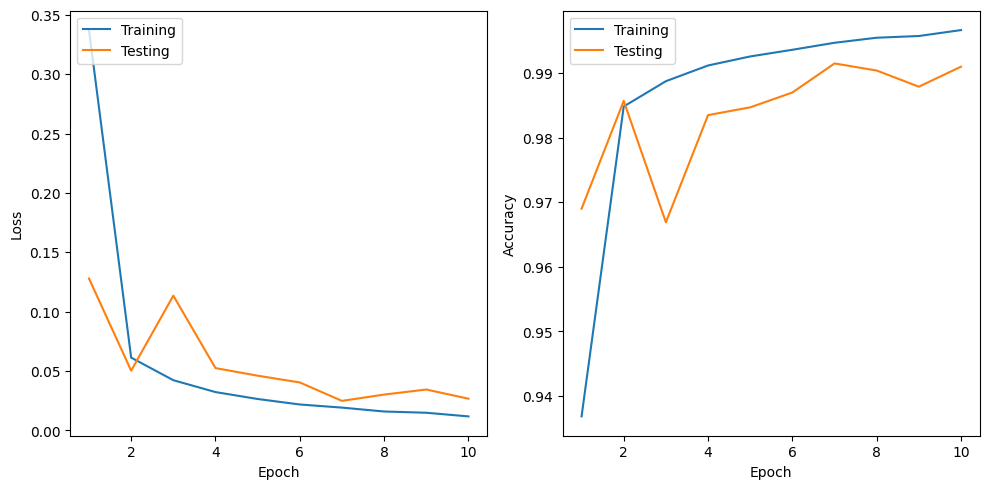

In [18]:
# 已繼續訓練 model 時，**不要**執行此儲存格
# 繪製 Loss-Accuracy 曲線
show_training_log(logs, epochs)

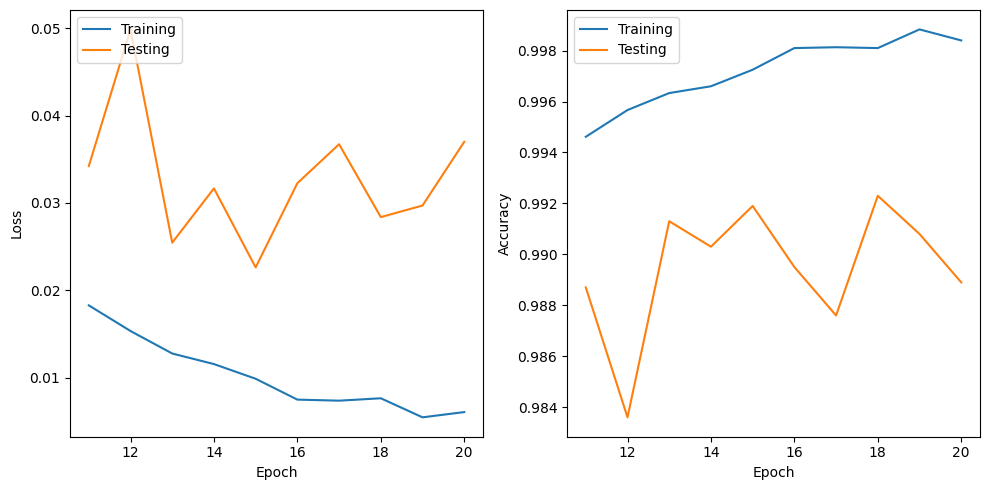

In [15]:
# 繪製繼續訓練 model 後的曲線
show_training_log(logs, epochs, st_epoch=11)

In [16]:
def start_testing():
    results = {'labels': [], 'preds': []}
    
    model.eval()
    running_acc = 0.
    data_num = len(test_data.dataset)

    pbar = tqdm(test_data, unit='batch', desc='test: ')
    for b, batch in enumerate(pbar):
        images, labels = batch
        images, labels = images.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
        
        results['labels'] += labels.tolist() # 保存 label
        results['preds'] += preds.tolist() # 保存 predict
        
        running_acc += torch.sum(preds == labels).item()

        if b == len(pbar)-1:
            epoch_acc = running_acc/data_num
            pbar.set_postfix_str(f'acc: {epoch_acc:.4f}')
            
    return results

In [17]:
model = torch.load(models_dir/f'best_acc.pth').cuda() # 讀取 model
results = start_testing()

# 顯示混淆矩陣
pd.crosstab(results['labels'], results['preds'],
            rownames=['label'], colnames=['predict'])

test: 100%|████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 51.58batch/s, acc: 0.9923]


predict,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,978,0,0,0,0,0,1,1,0,0
1,0,1132,2,1,0,0,0,0,0,0
2,0,0,1031,1,0,0,0,0,0,0
3,0,0,2,1005,0,1,0,0,1,1
4,0,0,0,0,977,0,2,0,0,3
5,1,0,0,9,0,878,1,1,1,1
6,8,5,0,0,1,1,943,0,0,0
7,0,2,5,1,1,0,0,1016,0,3
8,3,0,1,0,1,0,0,0,968,1
